In [65]:
from matplotlib import pyplot as plt
import os
import numpy as np
import json
from sklearn.linear_model import LinearRegression
import pandas as pd


file_dir = "/data03/sunyi/time_constrained_cot/outputs/1_10"
latency_path = "/home/sunyi/CoT/Time-Constrained-CoT/latency/0115"
model_list = [
    "Qwen/QwQ-32B-Preview",
    "Qwen/Qwen2.5-32B-Instruct", 
    "Qwen/Qwen2.5-14B-Instruct", 
    "Qwen/Qwen2.5-7B-Instruct", 
    "Qwen/Qwen2.5-3B-Instruct", 
    "Qwen/Qwen2.5-1.5B-Instruct",   
    "mistralai/Mistral-Small-Instruct-2409",
    "mistralai/Mistral-Nemo-Instruct-2407" ,
    "mistralai/Ministral-8B-Instruct-2410",
    "mistralai/Mathstral-7B-v0.1",
    "google/gemma-2-27b-it",
    "google/gemma-2-9b-it",
    "google/gemma-2-2b-it",
    "microsoft/phi-4",
    "microsoft/Phi-3-medium-128k-instruct",
    "microsoft/Phi-3-small-128k-instruct",
    "microsoft/Phi-3-mini-128k-instruct",
    "microsoft/Phi-3.5-mini-instruct",
]

In [66]:
PROMP_LIST = [ "-quick", "-c2f"]
# PROMP_LIST = ["-sbs-hard", "-sbs", "-c2f", "-kf", "-aav"]


MODEL_SERIES_MAP = {
    "Qwen/QwQ-32B-Preview": "qwen",
    "Qwen/Qwen2.5-32B-Instruct": "qwen",
    "Qwen/Qwen2.5-14B-Instruct": "qwen",
    "Qwen/Qwen2.5-7B-Instruct": "qwen",
    "Qwen/Qwen2.5-3B-Instruct": "qwen",
    "Qwen/Qwen2.5-1.5B-Instruct": "qwen",
    "google/gemma-2-2b-it": "gemma",
    "google/gemma-2-9b-it": "gemma",
    "google/gemma-2-27b-it": "gemma",
    "mistralai/Mathstral-7B-v0.1": "mistral",
    "mistralai/Ministral-8B-Instruct-2410": "mistral",
    "mistralai/Mistral-Nemo-Instruct-2407": "mistral",
    "mistralai/Mistral-Small-Instruct-2409": "mistral",
    "microsoft/phi-4": "phi4",
    "microsoft/Phi-3-medium-128k-instruct": "phi3medium",
    "microsoft/Phi-3-small-128k-instruct": "phi3small",
    "microsoft/Phi-3.5-mini-instruct": "phi3mini",
    "microsoft/Phi-3-mini-128k-instruct": "phi3mini",
}


MODEL_SERIES_PROMPT_TYPE_MAP = {
    "qwen": ["qwen" + prompt for prompt in PROMP_LIST],
    "mistral": ["mistral"+prompt for prompt in PROMP_LIST],
    "gemma": ["gemma"+prompt for prompt in PROMP_LIST],
    "phi3mini": ["phi3mini"+prompt for prompt in PROMP_LIST],
    "phi3small": ["phi3small"+prompt for prompt in PROMP_LIST],
    "phi3medium": ["phi3medium"+prompt for prompt in PROMP_LIST],
    "phi4": ["phi4"+prompt for prompt in PROMP_LIST],
}

In [67]:
def gen_budget_latency_list(budget, data_name, model, prompt_type):
    if budget < 0:
        return [-1]
    elif budget == 0:
        return [25]
    else:
        if model in ["Qwen/QwQ-32B-Preview", "Skywork/Skywork-o1-Open-Llama-3.1-8B", "PowerInfer/SmallThinker-3B-Preview"]:
            if data_name == "gsm8k":
                budget_list = []
                for i in range(25, 600, 25):
                    budget_list.append(i)
                for i in range(600, 1201, 50):
                    budget_list.append(i)
            elif data_name in ["math", "math500"]:
                budget_list = []
                for i in range(25, 600, 25):
                    budget_list.append(i)
                for i in range(600, 2401, 50):
                    budget_list.append(i)
        else:    
            if data_name == "gsm8k":
                budget_list = []
                for i in range(25, 601, 25):
                    budget_list.append(i)
                # for i in range(600, 1001, 50):
                #     budget_list.append(i)
            elif data_name in ["math", "math500"]:
                budget_list = []
                for i in range(25, 600, 25):
                    budget_list.append(i)
                for i in range(600, 1201, 50):
                    budget_list.append(i)
    
    if "hard" not in prompt_type:
        budget_list = [budget + 25 for budget in budget_list]
    
    tokens = np.array([128, 256, 512, 1024])
    file = model.split("/")[-1] + "_a800.csv"
    df = pd.read_csv(os.path.join(latency_path, file))
    latencies = df.iloc[0, 1:].values  # Extract latency values for the first row
    # Perform linear regression on the measured latency data
    linear_model = LinearRegression()
    tokens = tokens.reshape(-1, 1)
    linear_model.fit(tokens, latencies)
    print(f"File: {file} - Linear Fit: Slope = {linear_model.coef_[0]:.2f}, Intercept = {linear_model.intercept_:.2f}")
    print(f"File: {file} - R^2 Score: {linear_model.score(tokens, latencies):.2f}")
    # change budget_list into latency_list using the linear regression model
    budget_list = np.array(budget_list)
    budget_list = budget_list.reshape(-1, 1)
    latency_list = linear_model.predict(budget_list)
    budget_list = budget_list.reshape(1, -1)[0]
    latency_list = latency_list.reshape(1, -1)[0]

    if "hard" not in prompt_type:
        budget_list = [budget - 25 for budget in budget_list]
        
    return budget_list, latency_list

In [68]:
dataset = "gsm8k"
something = "_-1_seed0_t0.0_s0_e-1"

In [69]:
model_acc_dicts = {}
model_latency_dicts = {}

for model in model_list:
    model_acc_dict = {}

    model_prompt_list = MODEL_SERIES_PROMPT_TYPE_MAP[MODEL_SERIES_MAP[model]]
    for prompt_type in model_prompt_list:
        budget_list, latency_list = gen_budget_latency_list(1, dataset, model, prompt_type)
        acc_list = []
        for budget in budget_list:
            file_name = "test_" + prompt_type + something + "_b" + str(int(budget)) + "_metrics.json"
            file_path = os.path.join(file_dir, model, prompt_type, dataset, file_name)
            with open(file_path, "r") as f:
                acc_list.append(json.load(f)["acc"])
        model_acc_dict[prompt_type] = acc_list
    model_acc_dicts[model] = model_acc_dict
    model_latency_dicts[model] = latency_list

model_latency_dicts

File: QwQ-32B-Preview_a800.csv - Linear Fit: Slope = 0.05, Intercept = -0.45
File: QwQ-32B-Preview_a800.csv - R^2 Score: 1.00
File: QwQ-32B-Preview_a800.csv - Linear Fit: Slope = 0.05, Intercept = -0.45
File: QwQ-32B-Preview_a800.csv - R^2 Score: 1.00
File: Qwen2.5-32B-Instruct_a800.csv - Linear Fit: Slope = 0.05, Intercept = -0.44
File: Qwen2.5-32B-Instruct_a800.csv - R^2 Score: 1.00
File: Qwen2.5-32B-Instruct_a800.csv - Linear Fit: Slope = 0.05, Intercept = -0.44
File: Qwen2.5-32B-Instruct_a800.csv - R^2 Score: 1.00
File: Qwen2.5-14B-Instruct_a800.csv - Linear Fit: Slope = 0.04, Intercept = 0.11
File: Qwen2.5-14B-Instruct_a800.csv - R^2 Score: 1.00
File: Qwen2.5-14B-Instruct_a800.csv - Linear Fit: Slope = 0.04, Intercept = 0.11
File: Qwen2.5-14B-Instruct_a800.csv - R^2 Score: 1.00
File: Qwen2.5-7B-Instruct_a800.csv - Linear Fit: Slope = 0.02, Intercept = -0.02
File: Qwen2.5-7B-Instruct_a800.csv - R^2 Score: 1.00
File: Qwen2.5-7B-Instruct_a800.csv - Linear Fit: Slope = 0.02, Intercept

{'Qwen/QwQ-32B-Preview': array([ 2.25250907,  3.60459835,  4.95668762,  6.3087769 ,  7.66086617,
         9.01295545, 10.36504473, 11.717134  , 13.06922328, 14.42131255,
        15.77340183, 17.12549111, 18.47758038, 19.82966966, 21.18175893,
        22.53384821, 23.88593748, 25.23802676, 26.59011604, 27.94220531,
        29.29429459, 30.64638386, 31.99847314, 33.35056242, 36.05474097,
        38.75891952, 41.46309807, 44.16727662, 46.87145517, 49.57563372,
        52.27981228, 54.98399083, 57.68816938, 60.39234793, 63.09652648,
        65.80070503]),
 'Qwen/Qwen2.5-32B-Instruct': array([ 2.26385876,  3.61433204,  4.96480533,  6.31527861,  7.66575189,
         9.01622518, 10.36669846, 11.71717175, 13.06764503, 14.41811832,
        15.7685916 , 17.11906488, 18.46953817, 19.82001145, 21.17048474,
        22.52095802, 23.87143131, 25.22190459, 26.57237787, 27.92285116,
        29.27332444, 30.62379773, 31.97427101, 33.3247443 ]),
 'Qwen/Qwen2.5-14B-Instruct': array([ 1.86154825,  2.738421

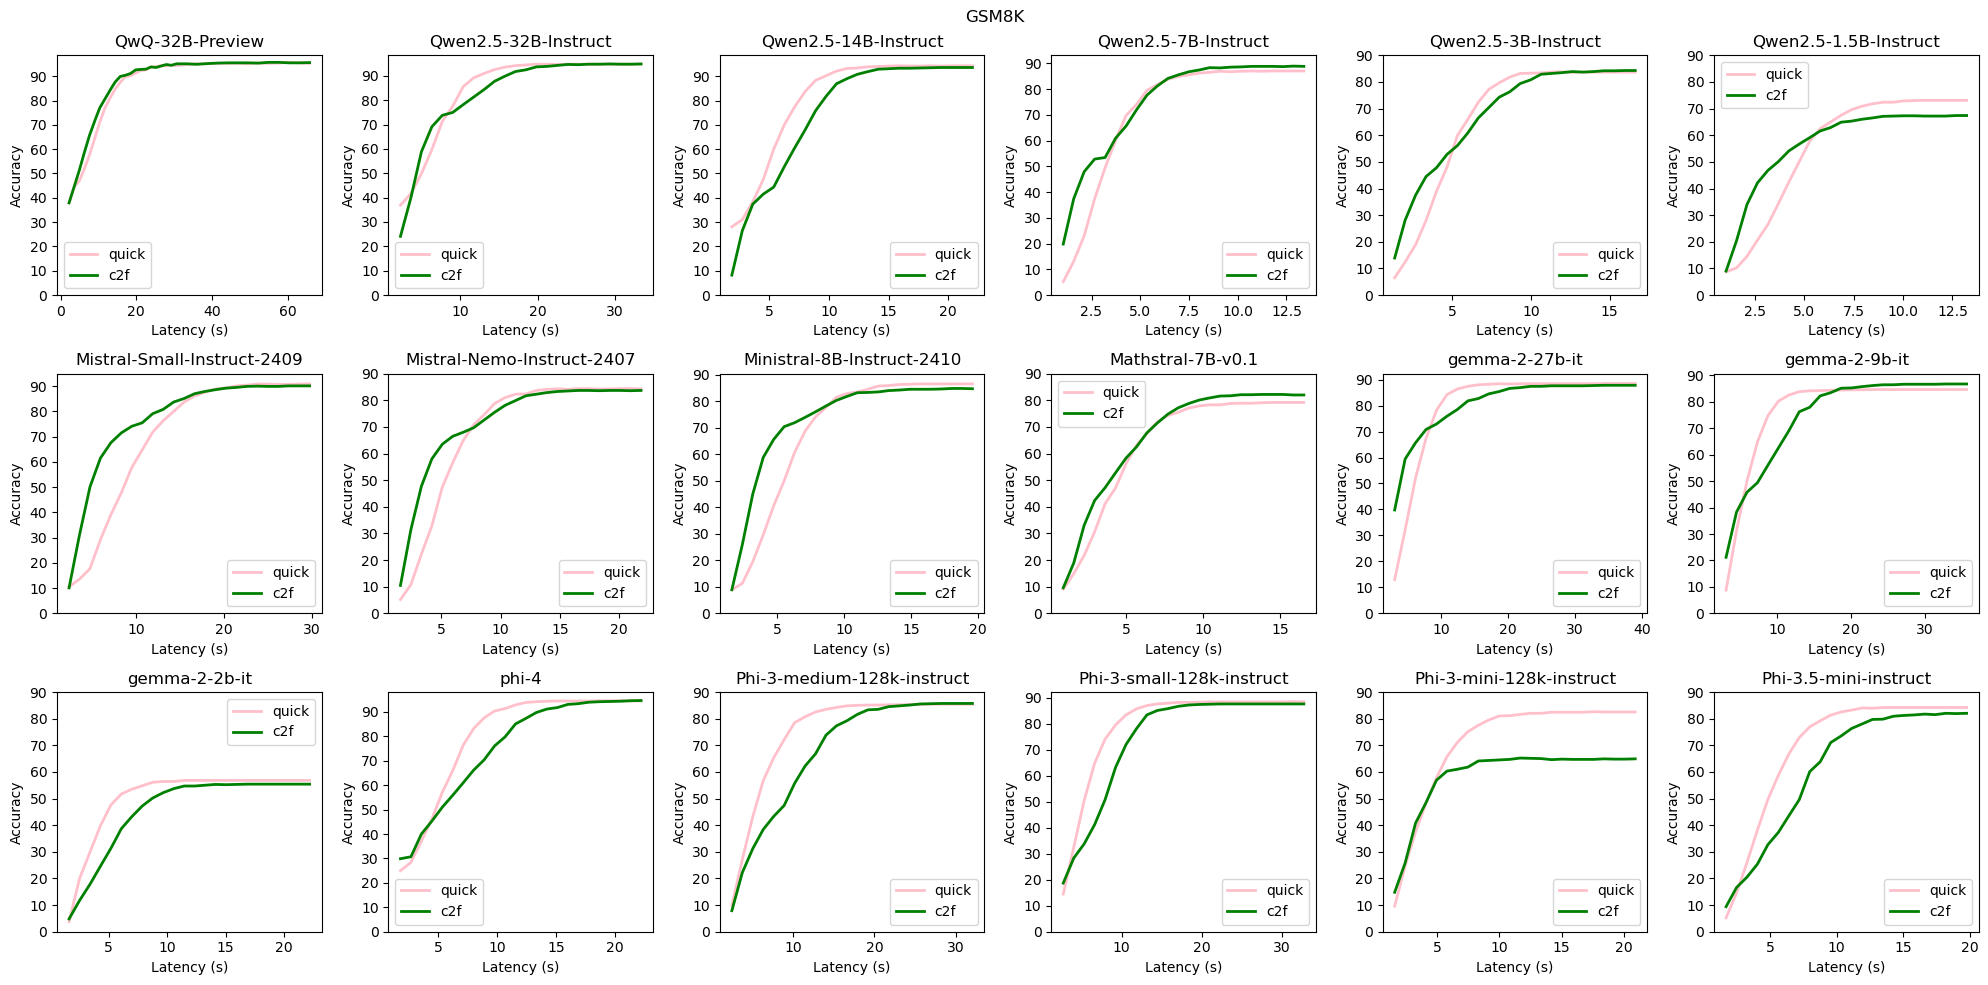

In [70]:
# Create a 2x3 subplot
fig, axs = plt.subplots(3, 6, figsize=(20, 10))
marker_size = 5  # Set the desired marker size
line_width = 2   # Set the desired line width

# Flatten the axes array for easy iteration
axs = axs.flatten()

# Plot all lines first without labels
for index, model in enumerate(model_list):
    model_prompt_list = MODEL_SERIES_PROMPT_TYPE_MAP[MODEL_SERIES_MAP[model]]
    for prompt_type in model_prompt_list:
        if "sbs-hard" in prompt_type:
            axs[index].plot(model_latency_dicts[model][1:], model_acc_dicts[model][prompt_type][1:], linestyle='--', color="red", label="sbs-hard", linewidth=line_width)
        elif "direct-hard" in prompt_type:
            axs[index].plot(model_latency_dicts[model][1:], model_acc_dicts[model][prompt_type][1:], linestyle='--', color="orange", label="direct-hard", linewidth=line_width)
        elif "quick-hard" in prompt_type:
            axs[index].plot(model_latency_dicts[model][1:], model_acc_dicts[model][prompt_type][1:], linestyle='--', color="pink", label="quick-hard", linewidth=line_width)
        elif "sbs" in prompt_type:
            axs[index].plot(model_latency_dicts[model], model_acc_dicts[model][prompt_type], linestyle='-', color="red", label="sbs", linewidth=line_width)
        elif "direct" in prompt_type:
            axs[index].plot(model_latency_dicts[model], model_acc_dicts[model][prompt_type], linestyle='-', color="orange", label="direct", linewidth=line_width)
        elif "quick" in prompt_type:
            axs[index].plot(model_latency_dicts[model], model_acc_dicts[model][prompt_type], linestyle='-', color="pink", label="quick", linewidth=line_width)
        elif "c2f" in prompt_type:
            axs[index].plot(model_latency_dicts[model], model_acc_dicts[model][prompt_type], linestyle='-', color="green", label="c2f", linewidth=line_width)
        # elif "kf" in prompt_type:
        #     axs[index].plot(model_latency_dicts[model], model_acc_dicts[model][prompt_type], linestyle='-', color="blue", label="kf", linewidth=line_width)
        elif "aav" in prompt_type:
            axs[index].plot(model_latency_dicts[model], model_acc_dicts[model][prompt_type], linestyle='-', color="purple", label="aav", linewidth=line_width)
        axs[index].set_xlabel("Latency (s)")
        axs[index].set_ylabel("Accuracy")
        axs[index].set_title(f"{model.split('/')[-1]}")
        axs[index].legend()
        
        # Set y-axis and x-axis ticks
        axs[index].set_yticks(range(0, 91, 10))  # Set y-axis interval to 10
        # axs[index].set_xticks(range(0, 551, 50))  # Set x-axis interval to 50

# set the title
plt.suptitle(f"{dataset}".upper())
# Adjust layout
plt.tight_layout()